In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
X_train = pd.read_csv('X_train.csv')
X_test = pd.read_csv('X_test.csv')
y_train = pd.read_csv('y_train.csv')
y_test = pd.read_csv('y_test.csv')

im checking for missing values

In [3]:
X_train.isnull().sum()
X_test.isnull().sum()
y_train.isnull().sum()
y_test.isnull().sum()

,0
filghtId,0
price,0


and now im gonna check and drop duplicate rows

In [4]:
X_train.drop_duplicates(inplace=True)
X_test.drop_duplicates(inplace=True)
y_train.drop_duplicates(inplace=True)
y_test.drop_duplicates(inplace=True)

 I ensure all categorical variables are strings and numerical variables are floats/integers:

In [5]:
for col in X_train.columns:
    X_train[col] = X_train[col].astype(str)
for col in X_test.columns:
    X_test[col] = X_test[col].astype(str)
for col in y_train.columns:
    y_train[col] = y_train[col].astype(float)
for col in y_test.columns:
    y_test[col] = y_test[col].astype(float)

 I need to combine data for encoding consistency

In [6]:
label_encoders = {}
for col in X_train.columns:
    combined_data = pd.concat([X_train[col], X_test[col]], axis=0).astype(str)

    # Apply LabelEncoder
    label_encoders[col] = LabelEncoder()
    label_encoders[col].fit(combined_data)

    # Transform training and test sets
    X_train[col] = label_encoders[col].transform(X_train[col].astype(str))
    X_test[col] = label_encoders[col].transform(X_test[col].astype(str))


converting target variables to numeric

In [7]:
y_train = y_train.astype(float)
y_test = y_test.astype(float)

im gonna check if all columns are numericaal

In [8]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')
X_test = X_test.apply(pd.to_numeric, errors='coerce')


validating final structure

In [9]:
print(X_train.info())
print(X_test.info())
print(y_train.info())
print(y_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5698 entries, 0 to 5697
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   filghtId          5698 non-null   int64
 1   airline           5698 non-null   int64
 2   flight            5698 non-null   int64
 3   source_city       5698 non-null   int64
 4   departure_time    5698 non-null   int64
 5   stops             5698 non-null   int64
 6   arrival_time      5698 non-null   int64
 7   destination_city  5698 non-null   int64
 8   duration          5698 non-null   int64
 9   days_left         5698 non-null   int64
dtypes: int64(10)
memory usage: 445.3 KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3347 entries, 0 to 3346
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   filghtId          3347 non-null   int64
 1   airline           3347 non-null   int64
 2   flight         

hyperparameter tuning using gridsearchcv

In [10]:
param_grid = {
    'max_depth': [3, 5, 7, 9, 11],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=DecisionTreeRegressor(random_state=42),
                           param_grid=param_grid,
                           scoring='neg_mean_squared_error',
                           cv=5,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Best Hyperparameters: {'max_depth': 11, 'min_samples_leaf': 1, 'min_samples_split': 10}


model training and evaluation withtthe best model

In [11]:
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 31085305.629861373
R-squared: 0.8576829988110591


visualizations

feature importance

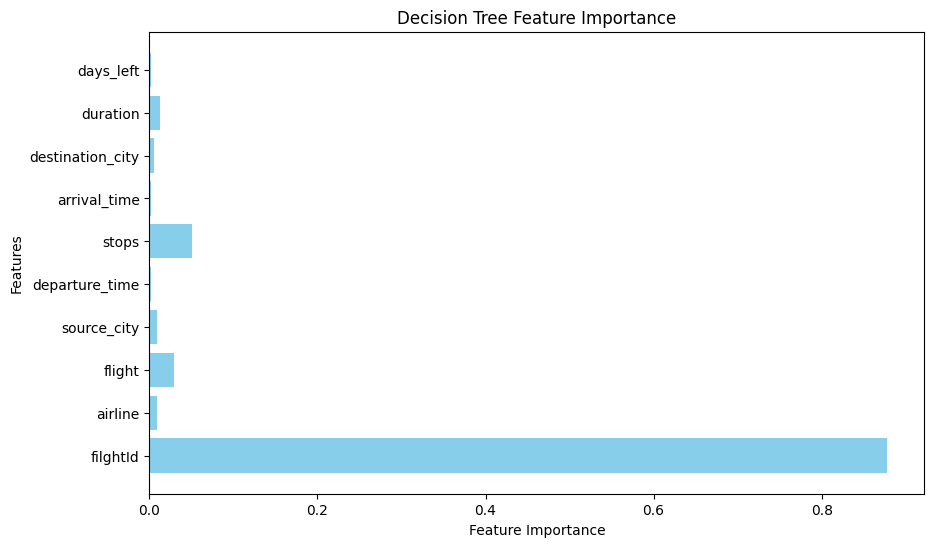

In [12]:
feature_importances = best_model.feature_importances_
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importances)), feature_importances, align='center', color='skyblue')
plt.yticks(range(len(feature_importances)), X_train.columns)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Decision Tree Feature Importance')
plt.show()

 Actual vs. Predicted Values Plot

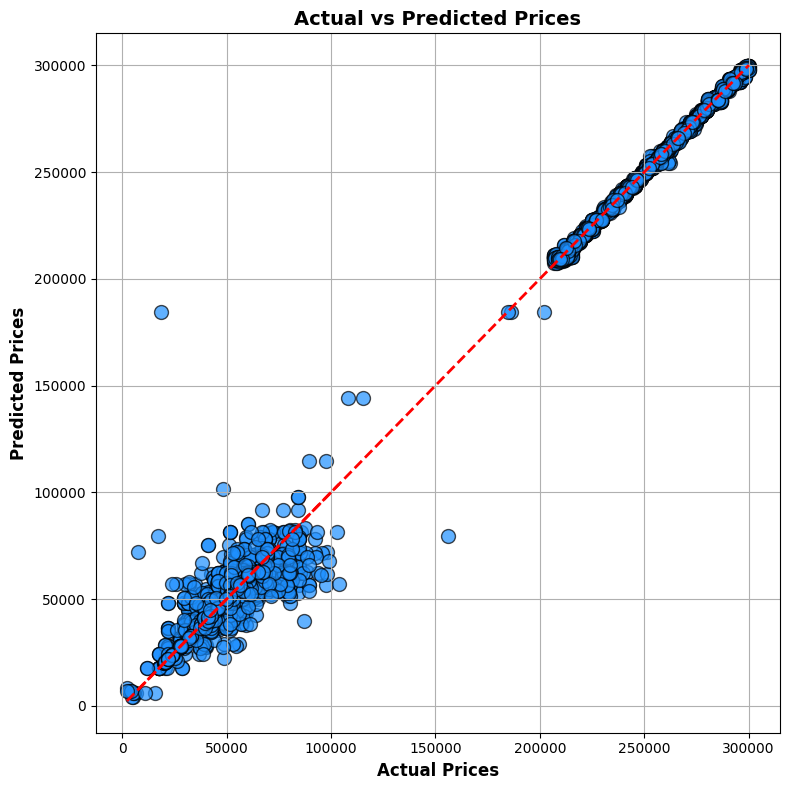

In [13]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.7, color='dodgerblue', edgecolors='black', s=100)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', linewidth=2)
plt.xlabel('Actual Prices', fontsize=12, fontweight='bold')
plt.ylabel('Predicted Prices', fontsize=12, fontweight='bold')
plt.title('Actual vs Predicted Prices', fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

residual plot

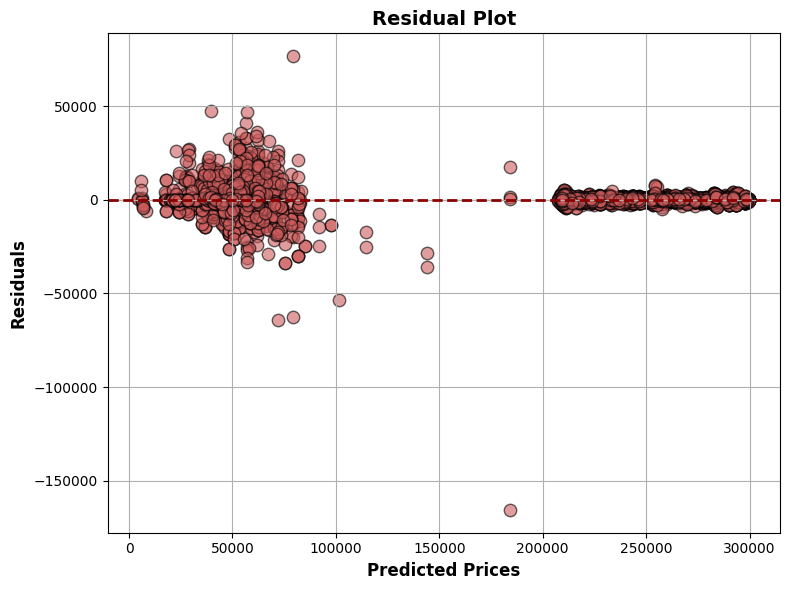

In [14]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuals, alpha=0.6, color='indianred', edgecolors='black', s=80)
plt.axhline(0, linestyle='--', color='darkred', linewidth=2)
plt.xlabel('Predicted Prices', fontsize=12, fontweight='bold')
plt.ylabel('Residuals', fontsize=12, fontweight='bold')
plt.title('Residual Plot', fontsize=14, fontweight='bold')
plt.grid(True)
plt.tight_layout()
plt.show()

learning curve

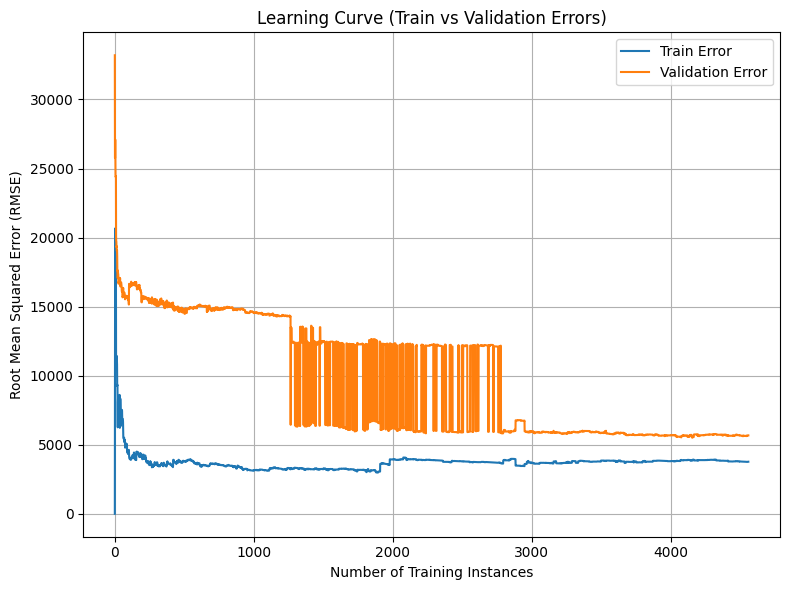

In [15]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

train_errors, val_errors = [], []

for m in range(1, len(X_train_split) + 1):
    best_model.fit(X_train_split[:m], y_train_split[:m])
    y_train_predict = best_model.predict(X_train_split[:m])
    y_val_predict = best_model.predict(X_val_split)

    train_errors.append(mean_squared_error(y_train_split[:m], y_train_predict))
    val_errors.append(mean_squared_error(y_val_split, y_val_predict))

plt.figure(figsize=(8, 6))
plt.plot(np.sqrt(train_errors), label="Train Error")
plt.plot(np.sqrt(val_errors), label="Validation Error")
plt.xlabel("Number of Training Instances")
plt.ylabel("Root Mean Squared Error (RMSE)")
plt.title("Learning Curve (Train vs Validation Errors)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Prediction Distribution Plot

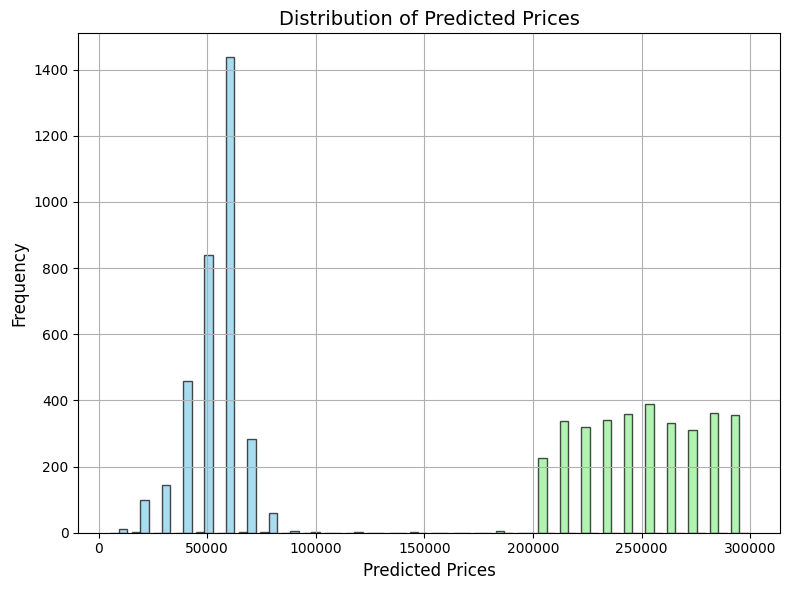

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(y_pred, bins=30, color=['lightgreen', 'skyblue'], edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Prices', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Distribution of Predicted Prices', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()

Residual Histogram


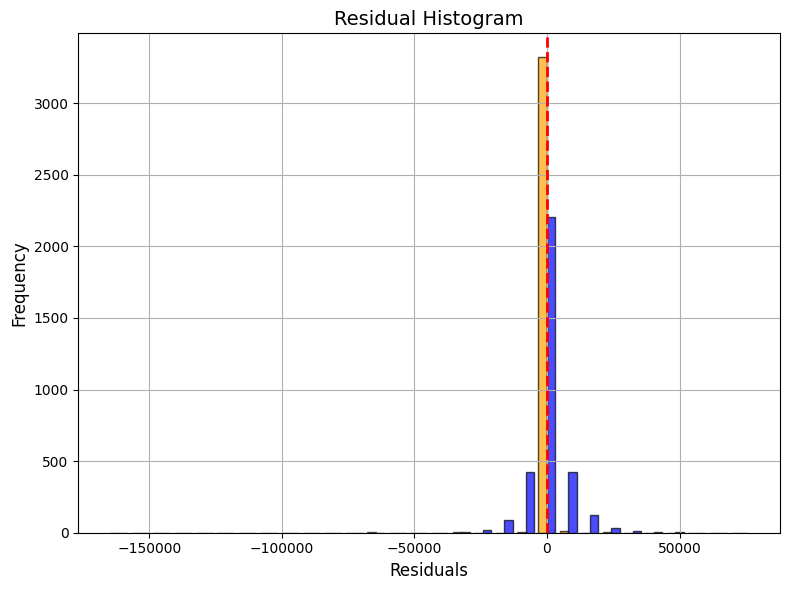

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(residuals, bins=30, color=['orange', 'blue'], edgecolor='black', alpha=0.7)
plt.axvline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residuals', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.title('Residual Histogram', fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.show()


heatmap

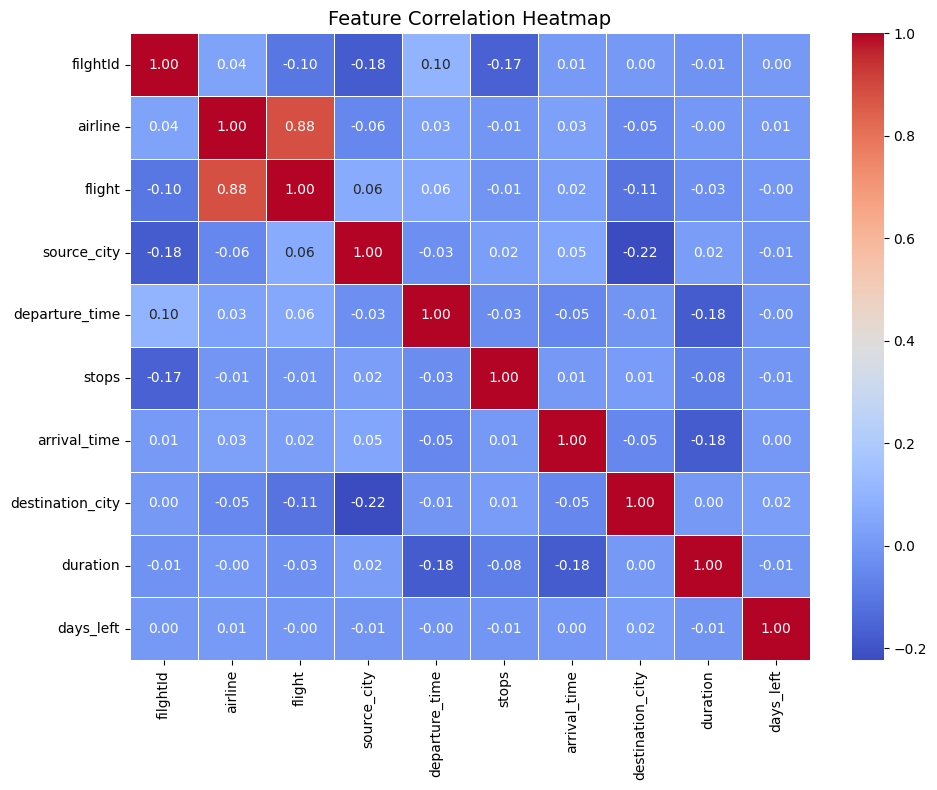

In [18]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Feature Correlation Heatmap', fontsize=14)
plt.tight_layout()
plt.show()

tree

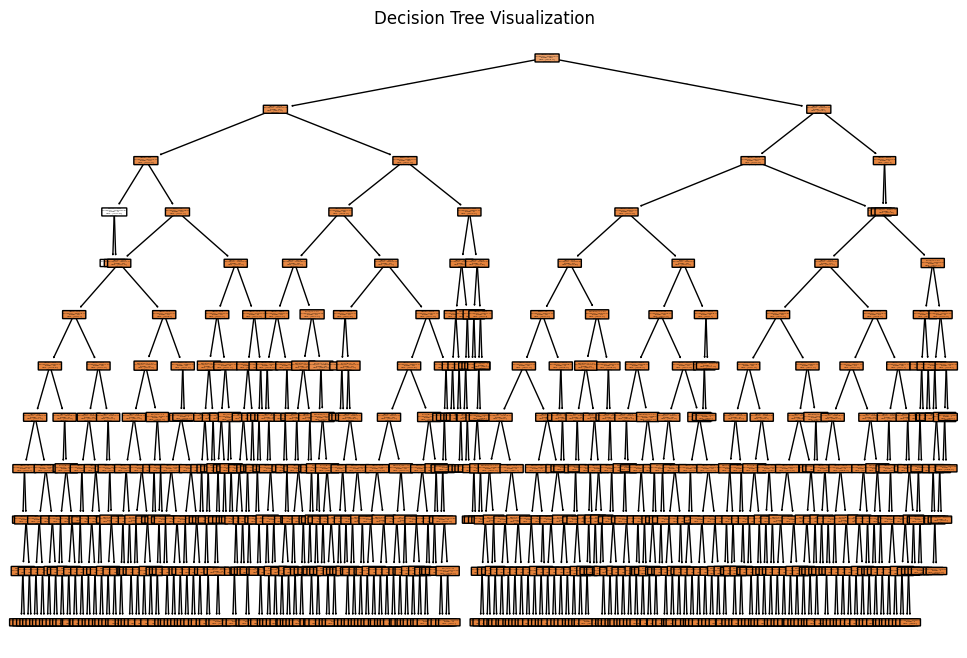

In [19]:
plt.figure(figsize=(12, 8))
plot_tree(best_model, feature_names=X_train.columns, filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()